<a href="https://colab.research.google.com/github/temurera/Deep-Learning/blob/master/SHM_Num_AE_04_Regul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
!nvidia-smi

Thu Mar 17 22:10:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%cd "/content/drive/My Drive/PhD_4th_Semester/SHM_PoliMI" 

#%python VAE_pre_proc.py
#from VAE_pre_proc import * # Loading the undamaged dataset

/content/drive/My Drive/PhD_4th_Semester/SHM_PoliMI


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pickle
from scipy import *
from pylab import figure, show, setp
#from mpl_toolkits.mplot3d import Axes3D

from keras.layers import Input, Dropout, BatchNormalization, Activation
from keras.layers.recurrent import LSTM
import matplotlib.pyplot as plt
from keras import regularizers
from keras import optimizers, Sequential 
from keras.layers import RepeatVector
from keras.layers import TimeDistributed, Dense
from tensorflow.keras import layers
from tensorflow.keras import activations

from keras.regularizers import l1

#from VAE_pre_proc import * # Loading the undamaged dataset
from VAE_SHM_num_pre_proc import * # Loading the undamaged dataset
U = np.transpose(U)

In [5]:
latent_dim = 10
n_timesteps = 120
n_features = 1

encoder_inputs = keras.Input(shape=(n_timesteps,1,1))
x = layers.Reshape((120, 1, 1))(encoder_inputs)
x = layers.Conv1D(kernel_size = 3, filters = 16, activation="tanh", strides=1, padding="same", kernel_regularizer =tf.keras.regularizers.l1( l=0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv1D(kernel_size = 7, filters = 32, activation="tanh", strides=1, padding="same", kernel_regularizer =tf.keras.regularizers.l1( l=0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv1D(kernel_size = 9, filters = 64, activation="tanh", strides=2, padding="same", kernel_regularizer =tf.keras.regularizers.l1( l=0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv1D(kernel_size = 9, filters = 128, activation="tanh", strides=3, padding="same", kernel_regularizer =tf.keras.regularizers.l1( l=0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv1D(kernel_size = 9, filters = 10, activation="tanh", strides=2, padding="same", kernel_regularizer =tf.keras.regularizers.l1( l=0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(latent_dim, activation="relu")(x)


#z_mean = layers.Dense(latent_dim, name="z_mean")(x)
#z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
#z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [x], name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 1, 1)]       0         
                                                                 
 reshape (Reshape)           (None, 120, 1, 1)         0         
                                                                 
 conv1d (Conv1D)             (None, 120, 1, 16)        64        
                                                                 
 batch_normalization (BatchN  (None, 120, 1, 16)       64        
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 120, 1, 32)        3616      
                                                                 
 batch_normalization_1 (Batc  (None, 120, 1, 32)       128       
 hNormalization)                                           

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
#x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = latent_inputs
x = layers.Reshape((latent_dim,1))(x)
x = layers.Conv1DTranspose(kernel_size = 9, filters = 128, activation="tanh", strides=3, padding="same", kernel_regularizer =tf.keras.regularizers.l1( l=0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv1DTranspose(kernel_size = 9, filters = 64, activation="tanh", strides=2, padding="same", kernel_regularizer =tf.keras.regularizers.l1( l=0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv1DTranspose(kernel_size = 9, filters = 32, activation="tanh", strides=2, padding="same", kernel_regularizer =tf.keras.regularizers.l1( l=0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv1DTranspose(kernel_size = 7, filters = 16, activation="tanh", strides=1, padding="same", kernel_regularizer =tf.keras.regularizers.l1( l=0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv1DTranspose(kernel_size = 3, filters = 1, activation="tanh", strides=1, padding="same", kernel_regularizer =tf.keras.regularizers.l1( l=0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
#x = layers.Conv1DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = x#layers.Conv1DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()



Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 reshape_1 (Reshape)         (None, 10, 1)             0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 30, 128)          1280      
 nspose)                                                         
                                                                 
 batch_normalization_5 (Batc  (None, 30, 128)          512       
 hNormalization)                                                 
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 60, 64)           73792     
 ranspose)                                                       
                                                           

In [ ]:
#[(int((len(U_b)-n_timesteps)/hx)),n_timesteps]

In [ ]:
#U_b = U[0:10000,6]/np.max(U[0:10000,6]) #S101 Data
U = np.transpose(U)
U_b_2 = U[0:10000,2]/np.max(U[0:10000,2]) #Numerical building data

U_b = U_b_2


n_timesteps = 120
batch_size = 32

#for i in range(print(int((len(rossler)-n_timesteps)/n_timesteps))):
#    x_train = rossler[0:n_timesteps]
d_num = n_timesteps
hx = 10

#new_ = np.zeros([d_num,int(sample_size),sens_num])
dat = np.zeros([(int((len(U_b)-n_timesteps)/hx)),n_timesteps])
for i in range((int((len(U_b)-n_timesteps)/hx))):
      dat[i,:] = U_b[(hx*i):((hx*i)+d_num)]#/(np.max(np.abs(U[(hx*i):((hx*i)+d_num),1])))



#x_train = tf.data.Dataset.from_tensor_slices(dat[0:120,:].reshape(dat.shape[1],120,1))
dat1 = dat[0:int((dat.shape[0])*0.9),:] #train data
asd = tf.convert_to_tensor(
    dat1.reshape(dat1.shape[0],n_timesteps,1), dtype=None, dtype_hint=None, name=None
)

dat2 = dat[(int((dat.shape[0])*0.9)):(int((dat.shape[0]))),:] #test data
test2 = tf.convert_to_tensor(
    dat2.reshape(dat2.shape[0],n_timesteps,1), dtype=None, dtype_hint=None, name=None
)
#print(.shape)

dat1.shape
datt = dat1

x_train = np.reshape(datt, (-1, 120,1))
train_dataset = tf.data.Dataset.from_tensor_slices((x_train))
train_dataset_0 = train_dataset.batch(100)


test = np.reshape(dat2, (-1, 120,1))
test_dataset = tf.data.Dataset.from_tensor_slices((test))
test_dataset_0 = test_dataset.batch(120)



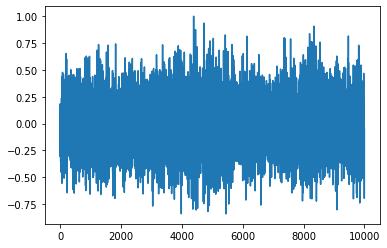

In [ ]:
plt.plot(U_b_2)

In [ ]:

print(x_train.shape)

(889, 120, 1)


In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        #self.fnn_loss

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                    keras.losses.mean_squared_error(data, reconstruction)                
            )
            #kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            #kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        #self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        #self.kl_loss_tracker.update_state(kl_loss)
        return {
            #"loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            #"kl_loss": self.kl_loss_tracker.result(),
        }

    '''def call(self, inputs):
      z_mean, z_log_var, z = self.encoder(data)
      reconstruction = self.decoder(z)
      reconstruction_loss = tf.reduce_mean(keras.losses.mean_squared_error(data, reconstruction))
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
      total_loss = reconstruction_loss*100 + kl_loss
      self.add_metric(kl_loss, name="kl_loss", aggregation='mean')
      self.add_metric(total_loss, name="total_loss", aggregation='mean')
      self.add_metric(reconstruction_loss, name="reconstruction_loss", aggregation='mean')
      return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }'''

    def test_step(self, data):
        #if isinstance(data, tuple):
        #  data = data[0]

        z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(keras.losses.mean_squared_error(data, reconstruction))
        #kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        #kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss*100 #+ kl_loss
        return {
            #"loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            #"kl_loss": self.kl_loss_tracker.result(),
        }
    '''def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        #self(x, training=False)
        #y_pred = self(x, training=False)
        [t1,t2,t3] = self.encoder(x ,training=False)
        y_pred = vae.decoder(t3)
        #print(tf.shape(out2))


        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}'''



#Sensor 2 training


In [ ]:
ae_1 = VAE(encoder, decoder)
#vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
#autoencoder = keras.Model(encoder_inputs, decoder_outputs)
ae_1.compile(optimizer=keras.optimizers.Adam(lr = 1e-3))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#input_shape=(120, 1, 1)
#model=vae(input_shape)

#_vae.compute_output_shape(input_shape=(None, 120, 1, 1))
#vae.save('./saved')

#vae.save('saved_vae')

#vae.save_weights('\saved_vae')
#vae._save_parameters('\saved_vae')
#vae.load_weights('trial_850')
#vae.load_weights("vae_noisy_0303900")
#epoch = 0
#ae_1.save_weights('./checkpoints/AE_trial_04_'+str(epoch+1))   

In [ ]:

import time
loss = []
loss_val = []
epochs = 10000
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train) in enumerate(train_dataset_0):
        loss_values = ae_1.train_step(x_batch_train)
        loss.append(loss_values)
        #print("loss {:1.2f}".format(loss.numpy()))
        # Log every 200 batches.
        if step % 10 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f recn "
                % (step, (float(loss_values["reconstruction_loss"]))))
            print("Seen so far: %d samples" % ((step + 1) * batch_size))
        if (epoch+1) % 500 == 0:
          ae_1.save_weights('./checkpoints/AE_trial_num_03_1'+str(epoch+1))          

    # Display metrics at the end of each epoch.
    #train_acc = train_acc_metric.result()
    #print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    #train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val in (test_dataset_0):
        val_loss = ae_1.test_step(x_batch_val)
        loss_val.append(val_loss)
        print("loss {:1.2f}".format(float(val_loss["reconstruction_loss"])))

    #vae.save_weights


Görüntülenen çıkış son 5000 satıra kısaltıldı.

Start of epoch 9000
Training loss (for one batch) at step 0: 0.0159 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 9001
Training loss (for one batch) at step 0: 0.0159 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 9002
Training loss (for one batch) at step 0: 0.0159 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 9003
Training loss (for one batch) at step 0: 0.0159 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 9004
Training loss (for one batch) at step 0: 0.0159 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 9005
Training loss (for one batch) at step 0: 0.0159 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 9006
Training loss (for one batch) at step 0: 0.0159 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 9007
Training loss (for one batch) at step 0: 0.0159 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 9008
Training loss (for one batch) at step 0: 0.0159 recn 
Seen s

In [ ]:
#ae_1.load_weights('./checkpoints/AE_trial_num_03_110000')

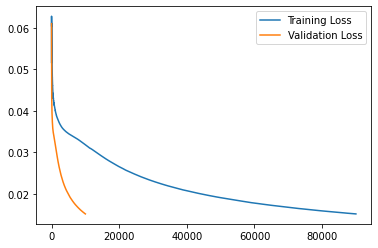

In [ ]:
loss_Loss = []
loss_RCN = []
loss_KL = []
loss_val_L = []
loss_val_RCN = []
loss_val_KL = []

for i in range(len(loss)):
  #loss_Loss.append(float(loss[i]["loss"]))
  loss_RCN.append(float(loss[i]["reconstruction_loss"]))
for i in range(len(loss_val)):
  loss_val_RCN.append((loss_val[i]["reconstruction_loss"]))
'''  loss_KL.append(float(loss[i]["kl_loss"]))
'''
import pickle
from google.colab import files
n_plt = 'AE_SHM_Num_003_1'
fig_object = plt.figure()
plt.plot(loss_RCN,label ='Training Loss')
plt.plot(loss_val_RCN,label ='Validation Loss')
plt.legend()
plt.savefig(n_plt+'.pdf')

#fig_object = plt.figure()
# Save to disk
pickle.dump(fig_object,open((n_plt+'.pickle'),'wb'))

ae_1.save_weights('./checkpoints/AE_Num_SHM_03_1')

In [ ]:
o3 = ae_1.encoder(asd)
out2 = ae_1.decoder(o3)
#print(tf.shape(out2))


for i in range(10):
    n_train = i+(80*i)#*120+5
    out2_np = out2.numpy()
    asd2_np = asd.numpy()
    plt.figure()
    plt.plot(out2_np[n_train,:,:], label='Reconstructed')
    #plt.plot(asd2_np[n_train,:,:], label='Actual')
    #print(out2_np[0,:,:].shape)
    plt.legend()


#Sensor 1 training

In [ ]:
#U_b = U[0:10000,6]/np.max(U[0:10000,6]) #S101 Data
U = np.transpose(U)
U_b_1 = U[0:10000,1]/np.max(U[0:10000,1]) #Numerical building data

U_b = U_b_1


n_timesteps = 120
batch_size = 32

#for i in range(print(int((len(rossler)-n_timesteps)/n_timesteps))):
#    x_train = rossler[0:n_timesteps]
d_num = n_timesteps
hx = 10

#new_ = np.zeros([d_num,int(sample_size),sens_num])
dat = np.zeros([(int((len(U_b)-n_timesteps)/hx)),n_timesteps])
for i in range((int((len(U_b)-n_timesteps)/hx))):
      dat[i,:] = U_b[(hx*i):((hx*i)+d_num)]#/(np.max(np.abs(U[(hx*i):((hx*i)+d_num),1])))



#x_train = tf.data.Dataset.from_tensor_slices(dat[0:120,:].reshape(dat.shape[1],120,1))
dat1 = dat[0:int((dat.shape[0])*0.9),:] #train data
asd = tf.convert_to_tensor(
    dat1.reshape(dat1.shape[0],n_timesteps,1), dtype=None, dtype_hint=None, name=None
)

dat2 = dat[(int((dat.shape[0])*0.9)):(int((dat.shape[0]))),:] #test data
test2 = tf.convert_to_tensor(
    dat2.reshape(dat2.shape[0],n_timesteps,1), dtype=None, dtype_hint=None, name=None
)
#print(.shape)


datt = dat1

x_train = np.reshape(datt, (-1, 120,1))
train_dataset = tf.data.Dataset.from_tensor_slices((x_train))
train_dataset_1 = train_dataset.batch(100)


test = np.reshape(dat2, (-1, 120,1))
test_dataset = tf.data.Dataset.from_tensor_slices((test))
test_dataset_1 = test_dataset.batch(120)


In [ ]:
ae_1_1 = VAE(encoder, decoder)
#vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
#autoencoder = keras.Model(encoder_inputs, decoder_outputs)
ae_1_1.compile(optimizer=keras.optimizers.Adam(lr = 1e-3))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
import time
loss = []
loss_val = []
epochs = 10000
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train) in enumerate(train_dataset_1):
        loss_values = ae_1_1.train_step(x_batch_train)
        loss.append(loss_values)
        #print("loss {:1.2f}".format(loss.numpy()))
        # Log every 200 batches.
        if step % 10 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f recn "
                % (step, (float(loss_values["reconstruction_loss"]))))
            print("Seen so far: %d samples" % ((step + 1) * batch_size))
        if (epoch+1) % 500 == 0:
          ae_1_1.save_weights('./checkpoints/AE_trial_num_03_2_'+str(epoch+1))          

    # Display metrics at the end of each epoch.
    #train_acc = train_acc_metric.result()
    #print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    #train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val in (test_dataset_1):
        val_loss = ae_1_1.test_step(x_batch_val)
        loss_val.append(val_loss)
        print("loss {:1.2f}".format(float(val_loss["reconstruction_loss"])))

    #vae.save_weights


Görüntülenen çıkış son 5000 satıra kısaltıldı.

Start of epoch 9000
Training loss (for one batch) at step 0: 0.0179 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 9001
Training loss (for one batch) at step 0: 0.0179 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 9002
Training loss (for one batch) at step 0: 0.0179 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 9003
Training loss (for one batch) at step 0: 0.0179 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 9004
Training loss (for one batch) at step 0: 0.0179 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 9005
Training loss (for one batch) at step 0: 0.0179 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 9006
Training loss (for one batch) at step 0: 0.0179 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 9007
Training loss (for one batch) at step 0: 0.0179 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 9008
Training loss (for one batch) at step 0: 0.0179 recn 
Seen s

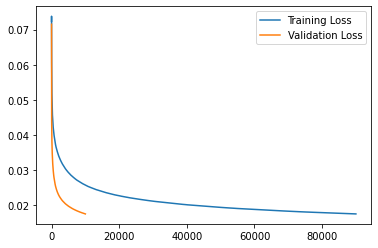

In [ ]:
loss_Loss = []
loss_RCN = []
loss_KL = []
loss_val_L = []
loss_val_RCN = []
loss_val_KL = []

for i in range(len(loss)):
  #loss_Loss.append(float(loss[i]["loss"]))
  loss_RCN.append(float(loss[i]["reconstruction_loss"]))
for i in range(len(loss_val)):
  loss_val_RCN.append((loss_val[i]["reconstruction_loss"]))
'''  loss_KL.append(float(loss[i]["kl_loss"]))
'''
import pickle
from google.colab import files
n_plt = 'AE_SHM_Num_003_2'
fig_object = plt.figure()
plt.plot(loss_RCN,label ='Training Loss')
plt.plot(loss_val_RCN,label ='Validation Loss')
plt.legend()
plt.savefig(n_plt+'.pdf')

#fig_object = plt.figure()
# Save to disk
pickle.dump(fig_object,open((n_plt+'.pickle'),'wb'))

ae_1.save_weights('./checkpoints/AE_Num_SHM_03_2')

#Sensor 0 training

In [ ]:
#U_b = U[0:10000,6]/np.max(U[0:10000,6]) #S101 Data
#U = np.transpose(U)
U_b_1 = U[0:10000,0]/np.max(U[0:10000,0]) #Numerical building data

U_b = U_b_1


n_timesteps = 120
batch_size = 32

#for i in range(print(int((len(rossler)-n_timesteps)/n_timesteps))):
#    x_train = rossler[0:n_timesteps]
d_num = n_timesteps
hx = 10

#new_ = np.zeros([d_num,int(sample_size),sens_num])
dat = np.zeros([(int((len(U_b)-n_timesteps)/hx)),n_timesteps])
for i in range((int((len(U_b)-n_timesteps)/hx))):
      dat[i,:] = U_b[(hx*i):((hx*i)+d_num)]#/(np.max(np.abs(U[(hx*i):((hx*i)+d_num),1])))



#x_train = tf.data.Dataset.from_tensor_slices(dat[0:120,:].reshape(dat.shape[1],120,1))
dat1 = dat[0:int((dat.shape[0])*0.9),:] #train data
asd = tf.convert_to_tensor(
    dat1.reshape(dat1.shape[0],n_timesteps,1), dtype=None, dtype_hint=None, name=None
)

dat2 = dat[(int((dat.shape[0])*0.9)):(int((dat.shape[0]))),:] #test data
test2 = tf.convert_to_tensor(
    dat2.reshape(dat2.shape[0],n_timesteps,1), dtype=None, dtype_hint=None, name=None
)
#print(.shape)

dat1.shape
datt = dat1

x_train = np.reshape(datt, (-1, 120,1))
train_dataset = tf.data.Dataset.from_tensor_slices((x_train))
train_dataset_2 = train_dataset.batch(100)


test = np.reshape(dat2, (-1, 120,1))
test_dataset = tf.data.Dataset.from_tensor_slices((test))
test_dataset_2 = test_dataset.batch(120)


In [ ]:
ae_1_2 = VAE(encoder, decoder)
#vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
#autoencoder = keras.Model(encoder_inputs, decoder_outputs)
ae_1_2.compile(optimizer=keras.optimizers.Adam(lr = 1e-3))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
import time
loss = []
loss_val = []
epochs = 10000
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train) in enumerate(train_dataset_2):
        loss_values = ae_1_2.train_step(x_batch_train)
        loss.append(loss_values)
        #print("loss {:1.2f}".format(loss.numpy()))
        # Log every 200 batches.
        if step % 10 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f recn "
                % (step, (float(loss_values["reconstruction_loss"]))))
            print("Seen so far: %d samples" % ((step + 1) * batch_size))
        if (epoch+1) % 500 == 0:
          ae_1_2.save_weights('./checkpoints/AE_trial_num_03_2_'+str(epoch+1))          

    # Display metrics at the end of each epoch.
    #train_acc = train_acc_metric.result()
    #print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    #train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val in (test_dataset_2):
        val_loss = ae_1_2.test_step(x_batch_val)
        loss_val.append(val_loss)
        print("loss {:1.2f}".format(float(val_loss["reconstruction_loss"])))

    #vae.save_weights


Görüntülenen çıkış son 5000 satıra kısaltıldı.

Start of epoch 9000
Training loss (for one batch) at step 0: 0.0265 recn 
Seen so far: 32 samples
loss 0.03

Start of epoch 9001
Training loss (for one batch) at step 0: 0.0265 recn 
Seen so far: 32 samples
loss 0.03

Start of epoch 9002
Training loss (for one batch) at step 0: 0.0265 recn 
Seen so far: 32 samples
loss 0.03

Start of epoch 9003
Training loss (for one batch) at step 0: 0.0265 recn 
Seen so far: 32 samples
loss 0.03

Start of epoch 9004
Training loss (for one batch) at step 0: 0.0265 recn 
Seen so far: 32 samples
loss 0.03

Start of epoch 9005
Training loss (for one batch) at step 0: 0.0265 recn 
Seen so far: 32 samples
loss 0.03

Start of epoch 9006
Training loss (for one batch) at step 0: 0.0265 recn 
Seen so far: 32 samples
loss 0.03

Start of epoch 9007
Training loss (for one batch) at step 0: 0.0265 recn 
Seen so far: 32 samples
loss 0.03

Start of epoch 9008
Training loss (for one batch) at step 0: 0.0265 recn 
Seen s

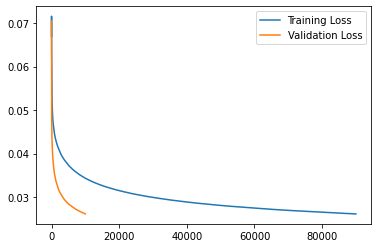

In [ ]:
loss_Loss = []
loss_RCN = []
loss_KL = []
loss_val_L = []
loss_val_RCN = []
loss_val_KL = []

for i in range(len(loss)):
  #loss_Loss.append(float(loss[i]["loss"]))
  loss_RCN.append(float(loss[i]["reconstruction_loss"]))
for i in range(len(loss_val)):
  loss_val_RCN.append((loss_val[i]["reconstruction_loss"]))
'''  loss_KL.append(float(loss[i]["kl_loss"]))
'''
import pickle
from google.colab import files
n_plt = 'AE_SHM_Num_003_3'
fig_object = plt.figure()
plt.plot(loss_RCN,label ='Training Loss')
plt.plot(loss_val_RCN,label ='Validation Loss')
plt.legend()
plt.savefig(n_plt+'.pdf')

#fig_object = plt.figure()
# Save to disk
pickle.dump(fig_object,open((n_plt+'.pickle'),'wb'))

ae_1_2.save_weights('./checkpoints/AE_Num_SHM_03_3_Last')

In [ ]:
#vae.save(filepath='my_model_01.h5')
#ae_1.load_weights("./checkpoints/AE_trial_03_4000")

In [ ]:
#train_dataset = tf.data.Dataset.from_tensor_slices((asd, asd))
#train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [ ]:
loss_Loss = []
loss_RCN = []
loss_KL = []
loss_val_L = []
loss_val_RCN = []
loss_val_KL = []

for i in range(len(loss)):
  #loss_Loss.append(float(loss[i]["loss"]))
  loss_RCN.append(float(loss[i]["reconstruction_loss"]))
'''  loss_KL.append(float(loss[i]["kl_loss"]))


for i in range(len(loss_val)):
  loss_val.append((loss_val[i]["reconstruction_loss"]))
  #loss_val_L.append(float(loss_val[i]["loss"]))
  loss_val_RCN.append(float(loss_val[i]["reconstruction_loss"]))
  loss_val_KL.append(float(loss_val[i]["kl_loss"]))
TR_L = np.array(loss_Loss).reshape(len(loss_Loss),1)
TR_RL = np.array(loss_RCN).reshape(len(loss_RCN),1) 
TR_KL = np.array(loss_KL).reshape(len(loss_KL),1) 

Loss_train1 = np.concatenate((TR_L,TR_RL,TR_KL), axis=1)  
T_loss_dataframe = pd.DataFrame(Loss_train1, columns=["Loss", "RCN", "KL"])

V_TR_L = np.array(loss_val_L).reshape(len(loss_val_L),1)
V_TR_RL = np.array(loss_val_RCN).reshape(len(loss_val_RCN),1) 
V_TR_KL = np.array(loss_val_KL).reshape(len(loss_val_KL),1) 

Loss_val1 = np.concatenate((V_TR_L,V_TR_RL,V_TR_KL), axis=1)  
V_loss_dataframe = pd.DataFrame(Loss_val1, columns=["Loss", "RCN", "KL"])

T_loss_dataframe.to_csv('TLoss.csv')
V_loss_dataframe.to_csv('VLoss.csv')
'''

'  loss_KL.append(float(loss[i]["kl_loss"]))\n\n\nfor i in range(len(loss_val)):\n  loss_val.append((loss_val[i]["reconstruction_loss"]))\n  #loss_val_L.append(float(loss_val[i]["loss"]))\n  loss_val_RCN.append(float(loss_val[i]["reconstruction_loss"]))\n  loss_val_KL.append(float(loss_val[i]["kl_loss"]))\nTR_L = np.array(loss_Loss).reshape(len(loss_Loss),1)\nTR_RL = np.array(loss_RCN).reshape(len(loss_RCN),1) \nTR_KL = np.array(loss_KL).reshape(len(loss_KL),1) \n\nLoss_train1 = np.concatenate((TR_L,TR_RL,TR_KL), axis=1)  \nT_loss_dataframe = pd.DataFrame(Loss_train1, columns=["Loss", "RCN", "KL"])\n\nV_TR_L = np.array(loss_val_L).reshape(len(loss_val_L),1)\nV_TR_RL = np.array(loss_val_RCN).reshape(len(loss_val_RCN),1) \nV_TR_KL = np.array(loss_val_KL).reshape(len(loss_val_KL),1) \n\nLoss_val1 = np.concatenate((V_TR_L,V_TR_RL,V_TR_KL), axis=1)  \nV_loss_dataframe = pd.DataFrame(Loss_val1, columns=["Loss", "RCN", "KL"])\n\nT_loss_dataframe.to_csv(\'TLoss.csv\')\nV_loss_dataframe.to_csv(

Saving the graph to drive using pickle and downloading it.

In [ ]:
asd1 = tf.convert_to_tensor(
    dat[0:240,:].reshape(240,120,1), dtype=None, dtype_hint=None, name=None
)


test = np.reshape(dat_test, (-1, 120,1))
test_dataset = tf.data.Dataset.from_tensor_slices((test))
test_dataset = test_dataset.batch(120)
#print(test_dataset)

o3 = ae_1.encoder(asd1)
out2 = ae_1.decoder(o3)
#print(tf.shape(out2))

n_train = 2
out2_np = out2.numpy()
asd2_np = asd1.numpy()
plt.plot(out2_np[n_train,:,:], label='predicted')
plt.plot(asd2_np[n_train,:,:], label='Actual')
#print(out2_np[0,:,:].shape)
plt.legend()




At = ae_1.predict(train_X[2240:40000,:,:])
i = 120
a = 0
for i in range(10):
  
  plt.figure()
  plt.plot(test_X[a,:,:])
  plt.plot(At[a,:,:])
  a = a+1280


In [ ]:
print(test.shape)

(99, 120, 1)


In [ ]:
val_loss_tests = ae_1.test_step(test2)

In [ ]:
print(len(val_loss_tests)

AttributeError: ignored

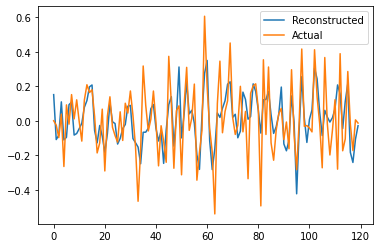

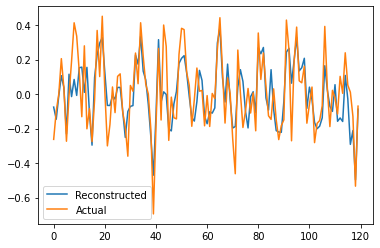

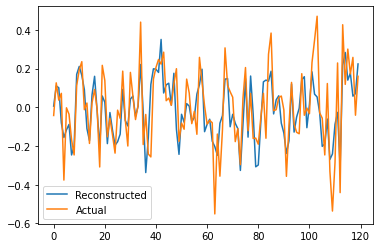

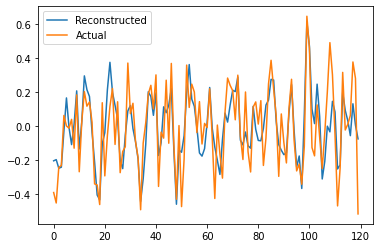

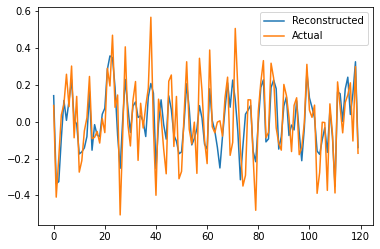

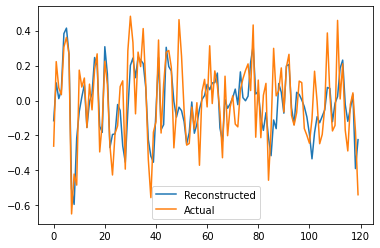

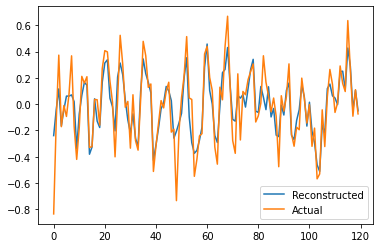

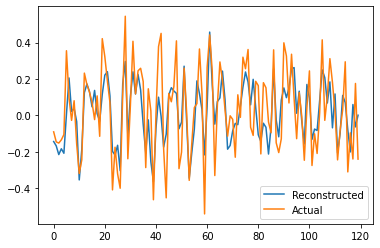

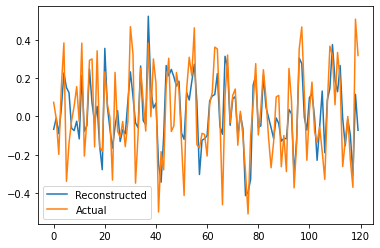

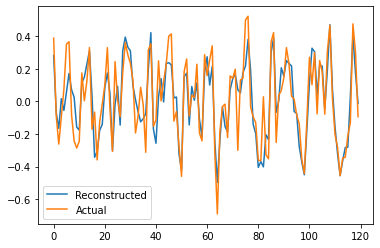

In [ ]:

o3 = ae_1_2.encoder(asd)
out2 = ae_1_2.decoder(o3)
#print(tf.shape(out2))


for i in range(10):
    n_train = i+(80*i)#*120+5
    out2_np = out2.numpy()
    asd2_np = asd.numpy()
    plt.figure()
    plt.plot(out2_np[n_train,:,:], label='Reconstructed')
    plt.plot(asd2_np[n_train,:,:], label='Actual')
    #print(out2_np[0,:,:].shape)
    plt.legend()


In [ ]:

dat2 = dat[(int((dat.shape[0])*0.9)):(int((dat.shape[0]))),:] #test data
test2 = tf.convert_to_tensor(
    dat2.reshape(dat2.shape[0],n_timesteps,1), dtype=None, dtype_hint=None, name=None
)

In [ ]:
print(dat2.shape)

(99, 120)


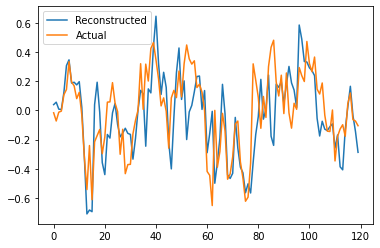

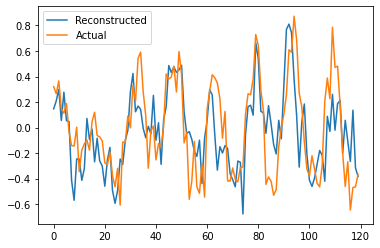

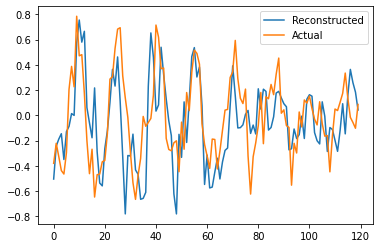

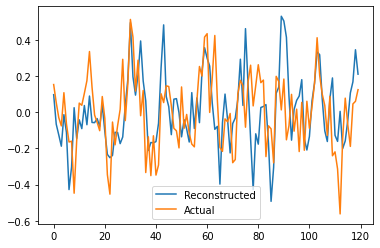

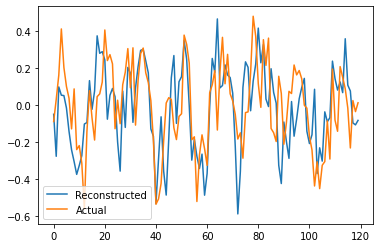

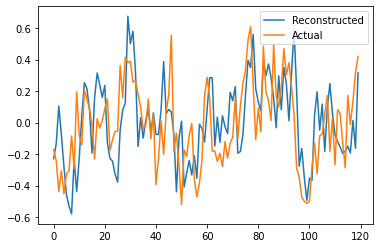

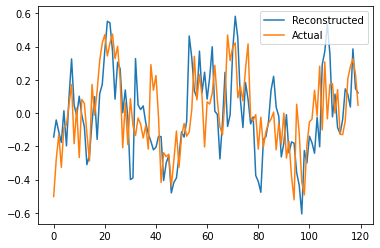

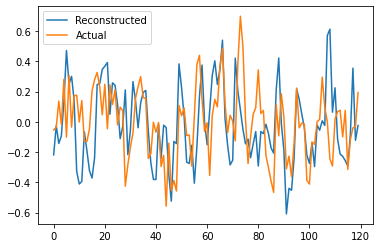

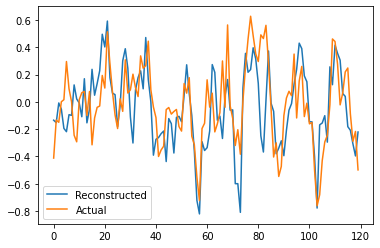

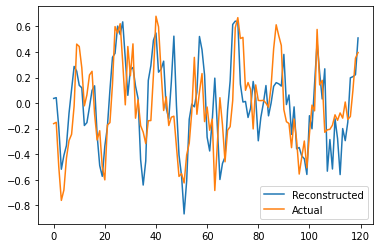

In [ ]:

o3_t = ae_1.encoder(test2)
out_test = ae_1.decoder(o3_t)
#print(tf.shape(out2))

for i in range(10):
    n_train = (10*i)#*120+5
    out_t_np = out_test.numpy()
    test_np = test2.numpy()
    plt.figure()
    plt.plot(out_t_np[n_train,:,:], label='Reconstructed')
    plt.plot(test_np[n_train,:,:], label='Actual')
    #print(out2_np[0,:,:].shape)
    plt.legend()

In [ ]:
n_train =500
out2_np = out2.numpy()
asd2_np = asd.numpy()
plt.figure()
plt.plot(out2_np[n_train,:,:], label='predicted')
plt.plot(asd2_np[n_train,:,:], label='Actual')
#print(out2_np[0,:,:].shape)
plt.legend()

In [ ]:
print(asd.shape)

(8892, 120, 1)


#Sensor 3 training


In [7]:
print(U.shape)

(5, 75000)


In [10]:
#U_b = U[0:10000,6]/np.max(U[0:10000,6]) #S101 Data

U_b_3 = U[0:10000,3]/np.max(U[0:10000,3]) #Numerical building data

U_b = U_b_3


n_timesteps = 120
batch_size = 32

#for i in range(print(int((len(rossler)-n_timesteps)/n_timesteps))):
#    x_train = rossler[0:n_timesteps]
d_num = n_timesteps
hx = 10

#new_ = np.zeros([d_num,int(sample_size),sens_num])
dat = np.zeros([(int((len(U_b)-n_timesteps)/hx)),n_timesteps])
for i in range((int((len(U_b)-n_timesteps)/hx))):
      dat[i,:] = U_b[(hx*i):((hx*i)+d_num)]#/(np.max(np.abs(U[(hx*i):((hx*i)+d_num),1])))



#x_train = tf.data.Dataset.from_tensor_slices(dat[0:120,:].reshape(dat.shape[1],120,1))
dat1 = dat[0:int((dat.shape[0])*0.9),:] #train data
asd = tf.convert_to_tensor(
    dat1.reshape(dat1.shape[0],n_timesteps,1), dtype=None, dtype_hint=None, name=None
)

dat2 = dat[(int((dat.shape[0])*0.9)):(int((dat.shape[0]))),:] #test data
test2 = tf.convert_to_tensor(
    dat2.reshape(dat2.shape[0],n_timesteps,1), dtype=None, dtype_hint=None, name=None
)
#print(.shape)

dat1.shape
datt = dat1

x_train = np.reshape(datt, (-1, 120,1))
train_dataset = tf.data.Dataset.from_tensor_slices((x_train))
train_dataset_4 = train_dataset.batch(100)


test = np.reshape(dat2, (-1, 120,1))
test_dataset = tf.data.Dataset.from_tensor_slices((test))
test_dataset_4 = test_dataset.batch(120)



In [11]:
ae__4 = VAE(encoder, decoder)
#vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
#autoencoder = keras.Model(encoder_inputs, decoder_outputs)
ae__4.compile(optimizer=keras.optimizers.Adam(lr = 1e-3))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
import time
loss = []
loss_val = []
epochs = 20000
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train) in enumerate(train_dataset_4):
        loss_values = ae__4.train_step(x_batch_train)
        loss.append(loss_values)
        #print("loss {:1.2f}".format(loss.numpy()))
        # Log every 200 batches.
        if step % 10 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f recn "
                % (step, (float(loss_values["reconstruction_loss"]))))
            print("Seen so far: %d samples" % ((step + 1) * batch_size))
        if (epoch+1) % 500 == 0:
          ae__4.save_weights('./checkpoints/AE_trial_num_03_4_'+str(epoch+1))          

    # Display metrics at the end of each epoch.
    #train_acc = train_acc_metric.result()
    #print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    #train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val in (test_dataset_4):
        val_loss = ae__4.test_step(x_batch_val)
        loss_val.append(val_loss)
        print("loss {:1.2f}".format(float(val_loss["reconstruction_loss"])))

    #vae.save_weights


Görüntülenen çıkış son 5000 satıra kısaltıldı.

Start of epoch 19000
Training loss (for one batch) at step 0: 0.0111 recn 
Seen so far: 32 samples
loss 0.01

Start of epoch 19001
Training loss (for one batch) at step 0: 0.0111 recn 
Seen so far: 32 samples
loss 0.01

Start of epoch 19002
Training loss (for one batch) at step 0: 0.0111 recn 
Seen so far: 32 samples
loss 0.01

Start of epoch 19003
Training loss (for one batch) at step 0: 0.0111 recn 
Seen so far: 32 samples
loss 0.01

Start of epoch 19004
Training loss (for one batch) at step 0: 0.0111 recn 
Seen so far: 32 samples
loss 0.01

Start of epoch 19005
Training loss (for one batch) at step 0: 0.0111 recn 
Seen so far: 32 samples
loss 0.01

Start of epoch 19006
Training loss (for one batch) at step 0: 0.0111 recn 
Seen so far: 32 samples
loss 0.01

Start of epoch 19007
Training loss (for one batch) at step 0: 0.0111 recn 
Seen so far: 32 samples
loss 0.01

Start of epoch 19008
Training loss (for one batch) at step 0: 0.0111 rec

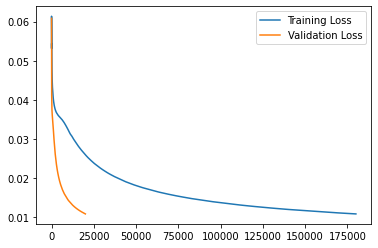

In [14]:
loss_Loss = []
loss_RCN = []
loss_KL = []
loss_val_L = []
loss_val_RCN = []
loss_val_KL = []

for i in range(len(loss)):
  #loss_Loss.append(float(loss[i]["loss"]))
  loss_RCN.append(float(loss[i]["reconstruction_loss"]))
for i in range(len(loss_val)):
  loss_val_RCN.append((loss_val[i]["reconstruction_loss"]))
'''  loss_KL.append(float(loss[i]["kl_loss"]))
'''
import pickle
from google.colab import files
n_plt = 'AE_SHM_Num_004_4th'
fig_object = plt.figure()
plt.plot(loss_RCN,label ='Training Loss')
plt.plot(loss_val_RCN,label ='Validation Loss')
plt.legend()
plt.savefig(n_plt+'.pdf')

#fig_object = plt.figure()
# Save to disk
pickle.dump(fig_object,open((n_plt+'.pickle'),'wb'))

ae__4.save_weights('./checkpoints/AE_Num_SHM_04_4th_sensor_Last')

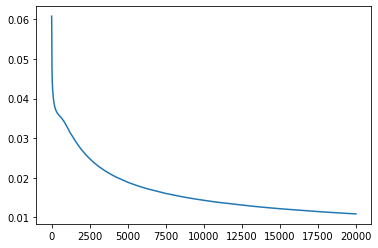

In [15]:
plt.plot(loss_val_RCN,label ='Validation Loss')

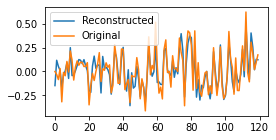

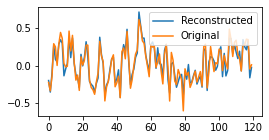

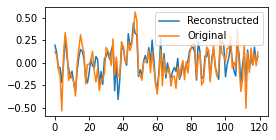

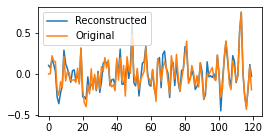

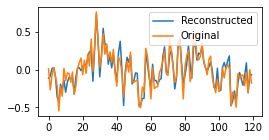

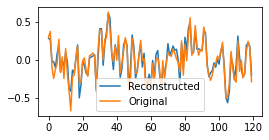

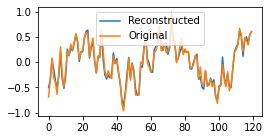

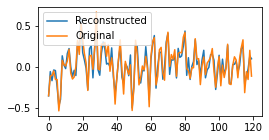

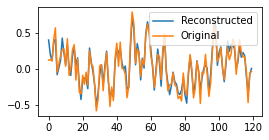

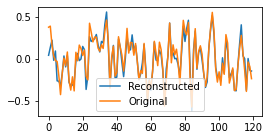

In [30]:
#o3 = ae__4.encoder(asd)
#out2 = ae__4.decoder(o3)
#print(tf.shape(out2))

#fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize = (6,15), dpi = 140)
plt_name = 'trial_'
for i in range(10):
    n_train = i+(80*i)#*120+5
    out2_np = out2.numpy()
    asd2_np = asd.numpy()
    plt.figure(figsize = (4,2))
    plt.plot(out2_np[n_train,:,:], label='Reconstructed')
    plt.plot(asd2_np[n_train,:,:], label='Original')
    #print(out2_np[0,:,:].shape)
    plt.legend()
    plt.savefig(plt_name+str(i)+'.pdf')
    pickle.dump(fig_object,open((plt_name+str(i)+'.pickle'),'wb'))


#Sensor 4 Training

In [31]:
#U_b = U[0:10000,6]/np.max(U[0:10000,6]) #S101 Data

U_b_3 = U[0:10000,4]/np.max(U[0:10000,4]) #Numerical building data

U_b = U_b_3


n_timesteps = 120
batch_size = 32

#for i in range(print(int((len(rossler)-n_timesteps)/n_timesteps))):
#    x_train = rossler[0:n_timesteps]
d_num = n_timesteps
hx = 10

#new_ = np.zeros([d_num,int(sample_size),sens_num])
dat = np.zeros([(int((len(U_b)-n_timesteps)/hx)),n_timesteps])
for i in range((int((len(U_b)-n_timesteps)/hx))):
      dat[i,:] = U_b[(hx*i):((hx*i)+d_num)]#/(np.max(np.abs(U[(hx*i):((hx*i)+d_num),1])))



#x_train = tf.data.Dataset.from_tensor_slices(dat[0:120,:].reshape(dat.shape[1],120,1))
dat1 = dat[0:int((dat.shape[0])*0.9),:] #train data
asd = tf.convert_to_tensor(
    dat1.reshape(dat1.shape[0],n_timesteps,1), dtype=None, dtype_hint=None, name=None
)

dat2 = dat[(int((dat.shape[0])*0.9)):(int((dat.shape[0]))),:] #test data
test2 = tf.convert_to_tensor(
    dat2.reshape(dat2.shape[0],n_timesteps,1), dtype=None, dtype_hint=None, name=None
)
#print(.shape)

dat1.shape
datt = dat1

x_train = np.reshape(datt, (-1, 120,1))
train_dataset = tf.data.Dataset.from_tensor_slices((x_train))
train_dataset_5 = train_dataset.batch(100)


test = np.reshape(dat2, (-1, 120,1))
test_dataset = tf.data.Dataset.from_tensor_slices((test))
test_dataset_5 = test_dataset.batch(120)



In [32]:


ae__5 = VAE(encoder, decoder)
#vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
#autoencoder = keras.Model(encoder_inputs, decoder_outputs)
ae__5.compile(optimizer=keras.optimizers.Adam(lr = 1e-3))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [33]:
import time
loss = []
loss_val = []
epochs = 20000
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train) in enumerate(train_dataset_5):
        loss_values = ae__5.train_step(x_batch_train)
        loss.append(loss_values)
        #print("loss {:1.2f}".format(loss.numpy()))
        # Log every 200 batches.
        if step % 10 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f recn "
                % (step, (float(loss_values["reconstruction_loss"]))))
            print("Seen so far: %d samples" % ((step + 1) * batch_size))
        if (epoch+1) % 500 == 0:
          ae__5.save_weights('./checkpoints/AE_trial_num_03_5_'+str(epoch+1))          

    # Display metrics at the end of each epoch.
    #train_acc = train_acc_metric.result()
    #print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    #train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val in (test_dataset_5):
        val_loss = ae__5.test_step(x_batch_val)
        loss_val.append(val_loss)
        print("loss {:1.2f}".format(float(val_loss["reconstruction_loss"])))

    #vae.save_weights


Görüntülenen çıkış son 5000 satıra kısaltıldı.

Start of epoch 19000
Training loss (for one batch) at step 0: 0.0159 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 19001
Training loss (for one batch) at step 0: 0.0159 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 19002
Training loss (for one batch) at step 0: 0.0159 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 19003
Training loss (for one batch) at step 0: 0.0159 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 19004
Training loss (for one batch) at step 0: 0.0159 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 19005
Training loss (for one batch) at step 0: 0.0159 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 19006
Training loss (for one batch) at step 0: 0.0159 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 19007
Training loss (for one batch) at step 0: 0.0159 recn 
Seen so far: 32 samples
loss 0.02

Start of epoch 19008
Training loss (for one batch) at step 0: 0.0159 rec

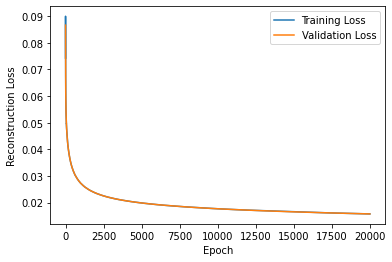

In [35]:
loss_Loss = []
loss_RCN = []
loss_KL = []
loss_val_L = []
loss_val_RCN = []
loss_val_KL = []

for i in range(len(loss)):
  #loss_Loss.append(float(loss[i]["loss"]))
  loss_RCN.append(float(loss[i]["reconstruction_loss"]))
for i in range(len(loss_val)):
  loss_val_RCN.append((loss_val[i]["reconstruction_loss"]))
'''  loss_KL.append(float(loss[i]["kl_loss"]))
'''
import pickle
from google.colab import files
n_plt = 'AE_SHM_Num_004_5th'
fig_object = plt.figure()
plt.plot(np.linspace(0,20000,len(loss_RCN)),loss_RCN,label ='Training Loss')
#plt.legend()
#plt.savefig(n_plt+'2.pdf')
#fig_object = plt.figure()
#plt.xlabel('Epoch')
#plt.ylabel('Reconstruction Loss')
plt.plot(loss_val_RCN,label ='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')

plt.legend()
plt.savefig(n_plt+'3.pdf')

#fig_object = plt.figure()
# Save to disk
pickle.dump(fig_object,open((n_plt+'.pickle'),'wb'))

ae__5.save_weights('./checkpoints/AE_Num_SHM_04_5th_sensor_Last')

#Loading all model

ValueError: ignored

In [101]:
len(A[0,:])

15000

In [7]:
from Damage_Scenarios_ import *

In [79]:
UA_E = np.zeros([90000,5])
for i in range(5):
    #AB[:,i] = np.append(A[i,:],B[i,:],0)
    #CD[:,i] = np.append(C[i,:],D[i,:],0)
    #A_D[:,i] = np.append(np.append(A[i,:],B[i,:],0),np.append(C[i,:],D[i,:],0),0)
    #A_E[:,i] = np.append(np.append(np.append(A[i,:],B[i,:],0),np.append(C[i,:],D[i,:],0),0),E[i,:],0)
#i = 0
    UA_E[:,i] = np.append(U[10000:25000,i],np.append(np.append(np.append(A[i,:],B[i,:],0),np.append(C[i,:],D[i,:],0),0),E[i,:],0),0)


In [99]:
U_b = np.zeros([90000,5])
n_timesteps = 120
batch_size = 32

#for i in range(print(int((len(rossler)-n_timesteps)/n_timesteps))):
#    x_train = rossler[0:n_timesteps]
d_num = n_timesteps
hx = 5

#new_ = np.zeros([d_num,int(sample_size),sens_num])
dat_S0 = np.zeros([(int((len(U_b)-n_timesteps)/hx)),n_timesteps,5])
for j in range(5):
    U_b[:,j] = UA_E[:,j]/np.max(np.abs(UA_E[:,j]))

    for i in range((int((len(U_b)-n_timesteps)/hx))):
        dat_S0[i,:,j] = U_b[(hx*i):((hx*i)+d_num),j]#/(np.max(np.abs(U[(hx*i):((hx*i)+d_num),1])))



    #x_train = tf.data.Dataset.from_tensor_slices(dat[0:120,:].reshape(dat.shape[1],120,1))
dat1 = dat_S0[0:int((dat_S0.shape[0])*0.9),:,:] #train data
asd_S0 = tf.convert_to_tensor(
    dat1.reshape(dat1.shape[0],n_timesteps,5), dtype=None, dtype_hint=None, name=None
)


In [113]:
tf.reshape(asd_S0[:,:,0],[asd_S0.shape[0],asd_S0.shape[1],1]).shape

TensorShape([16178, 120, 1])

In [29]:
print(U.shape)

(75000, 5)


In [105]:
ae_1 = VAE(encoder, decoder)
ae_1_1 = VAE(encoder, decoder)
ae_1_2 = VAE(encoder, decoder)
ae__4 = VAE(encoder, decoder)
ae__5 = VAE(encoder, decoder)

In [108]:
ae_1.load_weights('./checkpoints/AE_Num_SHM_03_1')
ae_1_1.load_weights('./checkpoints/AE_trial_num_03_2_10000')#+str(epoch+1))    
#ae_1_2.save_weights('./checkpoints/AE_trial_num_03_2_'+str(epoch+1))

ae_1_2.load_weights('./checkpoints/AE_Num_SHM_03_3_Last')
ae__4.load_weights('./checkpoints/AE_trial_num_03_4_20000')
ae__5.load_weights('./checkpoints/AE_trial_num_03_5_20000')


In [146]:
#ae_1_2 = VAE(encoder, decoder)
#ae_1_2.load_weights('./checkpoints/AE_Num_SHM_03_3_Last')
#asd_S0.shape
o_0 = tf.zeros(
    (16178,10,5), dtype=tf.dtypes.float32, name=None
)
#o_0=ae_1_2.encoder((asd_S0))
asd_S0.shape[0]

16178

In [194]:
o_0np = np.zeros([asd_S0.shape[0],10,asd_S0.shape[2]])
out_0np = np.zeros([asd_S0.shape[0],asd_S0.shape[1],1,asd_S0.shape[2]])
#for i in range(5):
i = 2
o_0 = ae_1.encoder(tf.reshape(asd_S0[:,:,i],[asd_S0.shape[0],asd_S0.shape[1],1]))
o_0np[:,:,i] = o_0.numpy()
out_0 = ae_1.decoder(o_0)
out_0np[:,:,:,i] = out_0.numpy()

i = 1
o_0 = ae_1_1.encoder(tf.reshape(asd_S0[:,:,i],[asd_S0.shape[0],asd_S0.shape[1],1]))
o_0np[:,:,i] = o_0.numpy()
out_0 = ae_1_1.decoder(o_0)
out_0np[:,:,:,i] = out_0.numpy()

i = 0
o_0 = ae_1_2.encoder(tf.reshape(asd_S0[:,:,i],[asd_S0.shape[0],asd_S0.shape[1],1]))
o_0np[:,:,i] = o_0.numpy()
out_0 = ae_1_2.decoder(o_0)
out_0np[:,:,:,i] = out_0.numpy()

i = 3
o_0 = ae__4.encoder(tf.reshape(asd_S0[:,:,i],[asd_S0.shape[0],asd_S0.shape[1],1]))
o_0np[:,:,i] = o_0.numpy()
out_0 = ae__4.decoder(o_0)
out_0np[:,:,:,i] = out_0.numpy()

i = 4
o_0 = ae__5.encoder(tf.reshape(asd_S0[:,:,i],[asd_S0.shape[0],asd_S0.shape[1],1]))
o_0np[:,:,i] = o_0.numpy()
out_0 = ae__5.decoder(o_0)
out_0np[:,:,:,i] = out_0.numpy()


'''
o_0 = ae_1_2.encoder(tf.reshape(asd_S0[:,:,i],[asd_S0.shape[0],asd_S0.shape[1],1]))
o_0np[:,:,i] = o_0.numpy()
out_0 = ae_1_2.decoder(o_0)
out_0np[:,:,:,i] = out_0.numpy()
#print(tf.shape(out2))
'''


'\no_0 = ae_1_2.encoder(tf.reshape(asd_S0[:,:,i],[asd_S0.shape[0],asd_S0.shape[1],1]))\no_0np[:,:,i] = o_0.numpy()\nout_0 = ae_1_2.decoder(o_0)\nout_0np[:,:,:,i] = out_0.numpy()\n#print(tf.shape(out2))\n'

In [195]:
asd_S0.shape

TensorShape([16178, 120, 5])

In [48]:
(len(np.linspace(0,len(AE_Loss_0),len(AE_Loss_0)))-5)/6

2695.5

In [196]:
mse = tf.keras.losses.MeanSquaredError()
AE_Loss_0 = np.zeros([out_0.shape[0],5])
for j in range(5):
  for i in range(out_0.shape[0]):
    AE_Loss_0[i,j] = (mse(asd_S0[i,:,j], out_0np[i,:,:,j]))



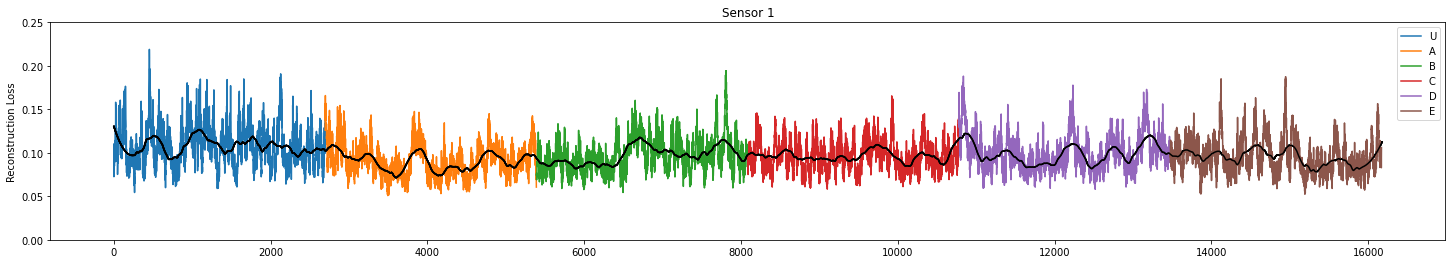

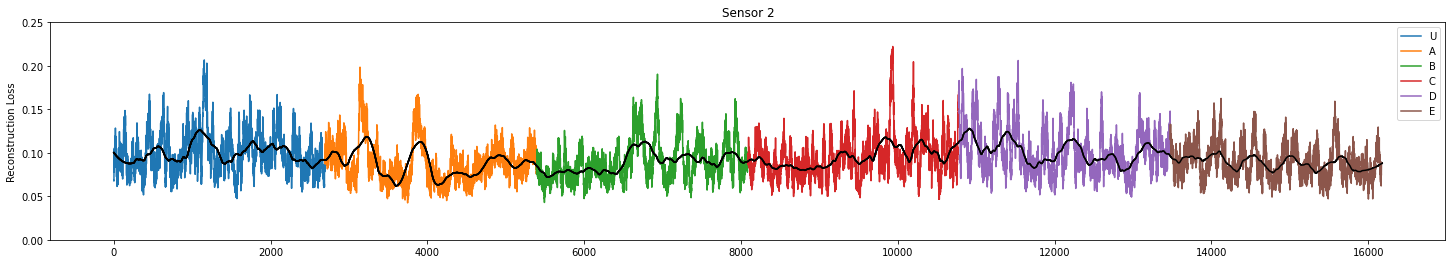

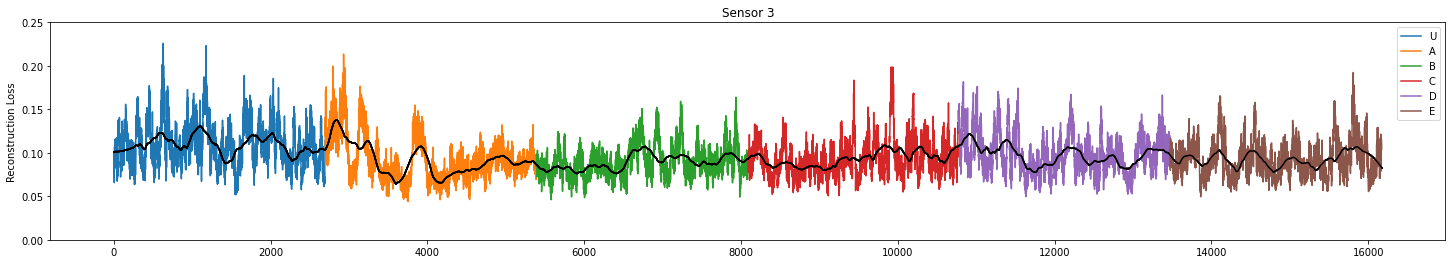

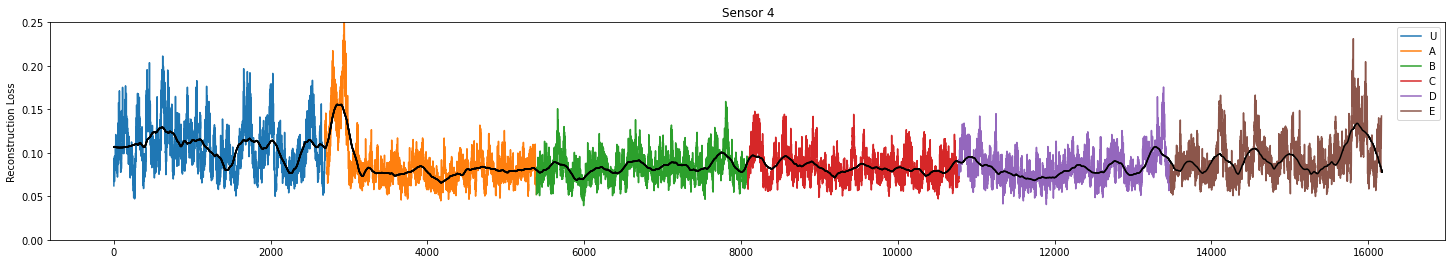

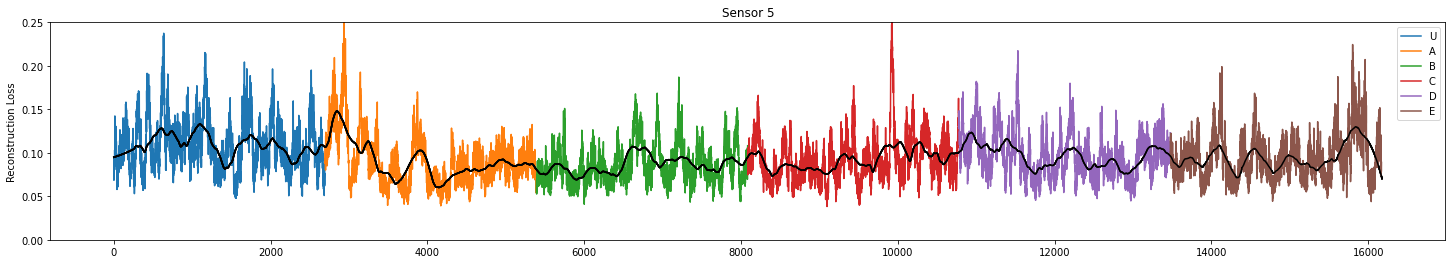

In [203]:
from scipy.signal import savgol_filter
#ax = plt.axes(projection='3d')
#ax.plot_wireframe(X, Y, Z, rstride=5, cstride=5)
x_ax = (np.linspace(0,len(AE_Loss_0),len(AE_Loss_0)))
seg_len = 2695
#plt.figure(figsize = [32,6,2])
#plt.ylim([0,0.25])
leg=['U','A','B','C','D','E']
titre=['Sensor 1','Sensor 2','Sensor 3','Sensor 4','Sensor 5']
Filen = 'n_plt_num_'

for j in range(5):
    plt.figure(figsize = [25,4])
    plt.title(titre[j])
    plt.ylim([0,0.25])
    for i in range(6):
        plt.plot(x_ax[(i)*seg_len:(i+1)*seg_len],AE_Loss_0[(i)*seg_len:(i+1)*seg_len,j],label=leg[i])
        yhat = savgol_filter(AE_Loss_0[:,j], 501, 2) # window size 51, polynomial order 3
        plt.plot(yhat, color='black')
        plt.legend()
        plt.ylabel('Reconstruction Loss')
    plt.savefig(Filen+str(j)+'_.pdf')
    

    #plt.plot(x,y)
    #plt.plot(yhat,j color='red')
#plt.show()

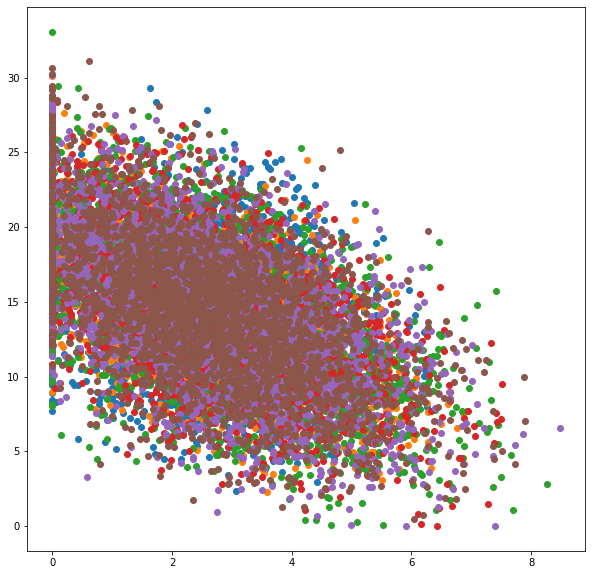

In [71]:
#plt.plot((o_0[:,0]),o_0[:,5])

a=0
plt.figure(figsize=[10,10])
for k in range(6):
    #plt.plot(x_ax[(i)*seg_len:(i+1)*seg_len],AE_Loss_0[(i)*seg_len:(i+1)*seg_len])
    #yhat = savgol_filter(AE_Loss_0, 501, 2) # window size 51, polynomial order 3
    #for i in range(10):
    #    for j in range(10):
          #plt.subplot(4, 25, a)
    
    plt.plot((o_0[(k)*seg_len:(k+1)*seg_len,]),o_0[(k)*seg_len:(k+1)*seg_len,2],'o')


